### <u>Objectives</u>
1. Perform basic data exploration prior to building a classifier model.
2. Run a logistic regression with scikit-learn. 
3. Run a linear discriminant analysis with scikit-learn. 
4. Run a quadratic discriminant analysis with scikit-learn.
5. Assess the correctness of a classification model using a variety of metrics.

This project uses a data set found in the journal article "Predictive modeling of wildfires: A new dataset and machine learning approach" by Sayad, Mousannif, and Al Moatassime. Various methods will be used to determine whether or not an area has experienced a wildfire based on information from satellite imagery.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Wildfire Dataset Data Exploration

In [2]:
df_WildFires = pd.read_csv("WildFires_DataSet.csv")
df_WildFires.head()

,NDVI,LST,THERMAL_ANOMALIES,CLASS
0,0.506782,14584.27273,4.692308,no_fire
1,0.522150,14655.83333,5.000000,no_fire
2,0.682284,14780.00000,5.000000,fire
3,0.120046,13298.50000,3.500000,no_fire
4,0.568734,14743.00000,5.000000,no_fire


<div class="alert alert-block alert-success">
<b>NDVI</b>: Normalized Difference Vegitation Index (NDVI) is the index of a crop's photosynthetic activity "greenness" and is considered as the most
widely used vegetation index. It is the fraction of the red and nearinfrared reflectance,
and it is useful for evaluating the health and density of vegetation. Values near 0 indicate very sparse vegetation and values near 1 indicate dense vegetation.<br><br>
<b>LST</b>: Land Surface Temperature (LST) represents the radiative temperature of the ground. It is the combination of vegetation and bare soil temperatures and is used to detect water-stressed crops. Higher temperatures indicate higher stress.<br><br>
<b>THERMAL_ANOMALIES</b>: Thermal anomalies (TA) give direct information on fire when it occurs (only when the fire is strong enough to be detected). This parameter is
available at 1-km resolution, and composed of fire pixels detected in
each grid cell daily and can be extracted from the MODIS product
“MOD14A1”. The higher the number, the stronger the indication of fire.<br><br>
<b>CLASS</b>: Binary response variable for wildfire prediction: "fire" or "no fire"
</div>



In [3]:
print(pd.unique(df_WildFires['CLASS']))

['no_fire' 'fire']


What is the probability that an observation in the df_WildFires dataset falls within the class "fire"? This is often shown as $\pi_k$ and denotes the prior probability that an observation belongs to the kth class and is most meaningful when the dataset is a random sample of the population. Here the kth class is the "fire" class. How does this relate to the trivial null classifier?

In [4]:
# πk simply represents the fraction of observations that belong to the "fire" class
# because the dataset is a random sample of the population

print(len(df_WildFires.loc[df_WildFires['CLASS'] == "fire"])/len(df_WildFires))

0.22533566841798014


<div class="alert alert-block alert-success">
The trivial null classifier is a classifier that always predicts "no fire". Whatever the prior probability (πk)
is for the positive class will also be the error rate of the trivial null classifier. If the prior probability of the "fire" class is really small, the error rate of the trivial null classifier will be equivalently low. Here, it looks like the accuracy of an unstandardized trivial null classifier would be around 77.5%.
</div>

In [5]:
df_WildFires.groupby("CLASS").mean()

,NDVI,LST,THERMAL_ANOMALIES
CLASS,,,
fire,0.533801,14818.157752,4.762614
no_fire,0.562025,14565.976683,4.649479


<div class="alert alert-block alert-success">
    These numbers make sense. For the fire categories, we expect to see <b>lower NDVI</b> (implies sparser vegetation),
    <b>higher LST</b> (implies higher radiative temperatures, more water-stressed crops), and <b>higher TA</b> (higher strength of indication of fire). These hypotheses hold true for all 3 features.
</div>

For most models, correlations between predictive variables can be problematic.

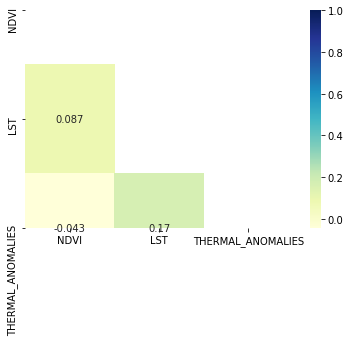

In [6]:
import seaborn as sns 

# Isolate the predictive variables (i.e. remove the response variable)
X = df_WildFires.drop(["CLASS"], axis = 1)

# Determine the correlations between the predictive variables
corr = X.corr()
   
# The correlation matrix will have values of one along the diagonal (a predictive variable
# correlated to itself). Information above this diagonal is duplicated below the diagonal.
# For example the correlation between LST and NDVI is the same as the correlation between
# NDVI and LST. Because of this, it is customary to only show half of the correlation matrix
# and mask the duplicate information.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Construct a heatmap of the correlation matrix
# Note "annot = True" shows the correlation coefficient in each cell
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask, cmap="YlGnBu",
        annot=True)
plt.show()

<div class="alert alert-block alert-success">
I do not anticipate the correlations between predictive variables to be problematic.
According to the textbook, "An element of [a correlation] matrix that is large in absolute value indicates a pair of highly correlated variables, and therefore a collinearity problem in the data."
Here, the largest correlation is between TA and LST, but it is only 0.17 (less than 0.5), so it does not seem large enough to be too problematic.
</div>

Let's convert the response categories into numerical values. If there is no fire, we will assign the class to be 0. If there is a fire, we will assign the class to be 1.

In [7]:
# Replace qualitative values with integers representing categories.
mapping = {'no_fire': 0, 'fire': 1}
df_WildFires = df_WildFires.replace({'CLASS': mapping})

# Isolate the response variable, y
y = df_WildFires["CLASS"]

Standardization of a dataset is a common requirement for many machine learning applications. We can standardize features by setting the mean to zero and scaling to a unit variance for each feature. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Isolate the predictive variable (features) in X
X = df_WildFires.drop(["CLASS"], axis = 1)

# Standardize the predictive variable (features)
X_std = scaler.fit_transform(X)

We are going to divide the dataset into a training set and testing set. This allows us to test how good our model is at classifying data it has not yet seen.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size = 0.2, # 20% of the data is in the test set and 80% of the data is in the training set
                                                    random_state = 0)

### 2. Logistic Regression 

We will use scikit-learn to train a logistic regression using the training data set. We will then test it using the testing data set. We will assess the model's performance by printing out both the model accuracy and confusion matrix.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Train a logistic regression model using the training data set
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Using the logistic regression model, predict whether or not their is a fire in each test observation
y_pred = logreg.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.755
The confusion matrix is:
[[245  11]
 [ 73  14]]


Let's interpret the results of this Linear Regression.

In [11]:
# confusion matrix reference according to sklearn implementation
#      0  1
# 0 [[TN FP]
# 1  [FN TP]]

def specificity(cm):
    # TN / (FP + TN)
    return round(cm[0,0] / (cm[0,1] + cm[0,0]), 3)

def sensitivity(cm):
    # TP / (TP + FN)
    return round(cm[1,1] / (cm[1,1] + cm[1,0]), 3)

def precision(cm):
    # TP / (TP + FP)
    return round(cm[1,1] / (cm[1,1] + cm[0,1]), 3)

In [12]:
specificity_lr = specificity(cnf_matrix)
sensitivity_lr = sensitivity(cnf_matrix)
precision_lr = precision(cnf_matrix)

In [13]:
print("LOGISTIC REGRESSION")
print("Specificity:\t", specificity_lr)
print("Sensitivity:\t", sensitivity_lr)
print("Precision:\t", precision_lr)

LOGISTIC REGRESSION
Specificity:	 0.957
Sensitivity:	 0.161
Precision:	 0.56


In [14]:
# the trivial null classifier always predicts 0 ("no fire")
y_pred = [0 for i in range(len(y_test))]

# Print the accuracy and confusion matrix of the trivial null classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of the trivial null classifier is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of the trivial null classifier is 0.746
The confusion matrix is:
[[256   0]
 [ 87   0]]


In [15]:
specificity_tnc = specificity(cnf_matrix)
sensitivity_tnc = sensitivity(cnf_matrix)
# precision_tnc = precision(cnf_matrix)

In [16]:
print("TRIVIAL NULL CLASSIFIER")
print("Specificity:\t", specificity_tnc)
print("Sensitivity:\t", sensitivity_tnc)
# print("Precision:\t", precision_tnc)

TRIVIAL NULL CLASSIFIER
Specificity:	 1.0
Sensitivity:	 0.0


<div class="alert alert-block alert-success">
The accuracy of this model is slightly higher than that of the trivial null classifier, but very comparable. The trivial null classifier
has zero sensitivity but perfect specificity. Its accuracy is 74.6%, whereas the accuracy of the logistic regression is 75.5% using the standardized data set.
</div>

There are more observations without fire than observations with fire. This represents an imbalance in the classes. Fortunately, LogisticRegression has a built-in option to address this imbalance: class_weight = 'balanced'. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Train a logistic regression model using the training data set
logreg_balanced = LogisticRegression(class_weight = 'balanced')
logreg_balanced.fit(X_train, y_train)

# Using the logistic regression model, predict whether or not their is a fire in each test observation
y_pred = logreg_balanced.predict(X_test)

# Print the confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.673
The confusion matrix is:
[[174  82]
 [ 30  57]]


Let's interpret the results of this balanced class logistic regression.

In [18]:
specificity_lr_bal = specificity(cnf_matrix)
sensitivity_lr_bal = sensitivity(cnf_matrix)
precision_lr_bal = precision(cnf_matrix)

In [19]:
print("Specificity:\t", specificity_lr_bal)
print("Sensitivity:\t", sensitivity_lr_bal)
print("Precision:\t", precision_lr_bal)

Specificity:	 0.68
Sensitivity:	 0.655
Precision:	 0.41


<div class="alert alert-block alert-success">
The balanced class logistic regression model has an accuracy of 67.3%, which is lower than the unbalanced logistic regression accuracy of 75.5%. Balancing the weights of the classes is important in many cases. While it may decrease accuracy, it typically improves the precision or recall depending on which class is underrepresented. It accomplishes this by adjusting the weights of the classes and essentially penalizing for the
the misclassification of the minority class more. This ensures that the model will be careful enough to learn how to classify that class and not neglect it or dismiss it due to its low population / frequency in the dataset.
An example of a case in which balancing the weights of the classes is particularly important is in the field of facial recognition where models are prone to algorithmic bias due to lack of representation of certain demographics.
</div>

ROC curves are useful to visualize the trade-offs between the true positive rates and false positive rates (at different thresholds), as well as compare different models.

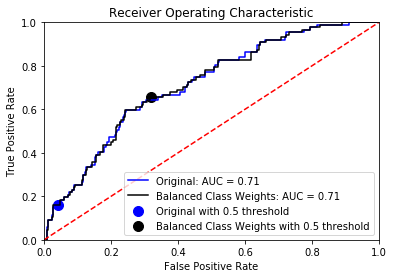

In [20]:
# Original Logistic Regression Model
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
fpr_50 = 1 - specificity_lr
tpr_50 = sensitivity_lr

# Balanced Logistic Regression Model
probs_balanced = logreg_balanced.predict_proba(X_test)
preds_balanced = probs_balanced[:,1]
fpr_balanced, tpr_balanced, threshold = metrics.roc_curve(y_test, preds_balanced)
roc_auc_balanced = metrics.auc(fpr_balanced, tpr_balanced)
fpr_50_balanced = 1 - specificity_lr_bal
tpr_50_balanced = sensitivity_lr_bal

# Create ROC curve plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Original: AUC = %0.2f' % roc_auc)
plt.scatter(fpr_50, tpr_50, s=100, marker='o', c='b', label = 'Original with 0.5 threshold')
plt.plot(fpr_balanced, tpr_balanced, 'black', label = 'Balanced Class Weights: AUC = %0.2f' % roc_auc_balanced)
plt.scatter(fpr_50_balanced, tpr_50_balanced, s=100, marker='o', c='black', label = 'Balanced Class Weights with 0.5 threshold')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<div class="alert alert-block alert-success">
(a) ROC curves trace out two types of error as we vary the threshold value for the posterior probability of fire. 
In other words, the true positive rate (sensitivity) is being plotted against the false positive rate (1 - specificity) at various thresholds for chance of fire. 
The curves are similar for both the original and balanced class weights because the ratio of true positive rate to false positive rate at various thresholds does not depend on the weights of the classes. As long as the same dataset is being used, the ratio of these two types of errors for the same type of classifier (logistic regression) will be consistent
at all thresholds, but the thresholds will be more evenly distributed through the curve for the logistic regression model with balanced class weights. <br>
(b) The dotted line represents the “no information” classifier or "dummy" classifier; this is what we would expect if the predictor variables were not associated with probability of fire. It represents a model that is no better than random guessing.
</div>

### 3. Linear Discriminant Analysis (LDA)

We will use scikit-learn to train a linear discriminant using the training data set. We will then test it using the testing data set. We will assess the model's performance by printing out both the model's accuracy and confusion matrix.

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Train an LDA model using the training data set
lda = LinearDiscriminantAnalysis(store_covariance =  True)
lda.fit(X_train, y_train)

# Use the LDA model to predict whether or not there is a fire in each test observation
y_pred = lda.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.758
The confusion matrix is:
[[247   9]
 [ 74  13]]


Let's interpret the results of this LDA.

In [22]:
specificity_lda = specificity(cnf_matrix)
sensitivity_lda = sensitivity(cnf_matrix)
precision_lda = precision(cnf_matrix)

In [23]:
print("Specificity:\t", specificity_lda)
print("Sensitivity:\t", sensitivity_lda)
print("Precision:\t", precision_lda)

Specificity:	 0.965
Sensitivity:	 0.149
Precision:	 0.591


<div class="alert alert-block alert-success">
The accuracy of the logistic regression (75.5%) is quite comparable to that of the LDA model (75.8%), with the LDA model being marginally more accurate. Even when comparing the confusion matrices, there are only a few samples for which the two models predicted different classes.
</div>

There are 3 predictive variables. It can be difficult to visualize in 3 dimensions. The following cells allow us to see the test data in 2D space. Blue markers indicates that there is no fire. Red markers indicate that there is fire. Circle markers indicate that the prediction was correct. X markers indicate that the prediction was incorrect. The means for each class is shown by a star.

In [24]:
def LDA_2D_plot(x_axis_col, y_axis_col):
    
    tp = (y_test == y_pred)  # True Positive
    tp0, tp1 = tp[y_test == 0], tp[y_test == 1]
    X0, X1 = X_test[y_test == 0], X_test[y_test == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, x_axis_col], X0_tp[:, y_axis_col], marker='.', color='blue')
    plt.scatter(X0_fp[:, x_axis_col], X0_fp[:, y_axis_col], marker='x',
                s=20, color='#000099')  # dark blue
    # class 1: dots
    plt.scatter(X1_tp[:, x_axis_col], X1_tp[:, y_axis_col], marker='.', color='red')
    plt.scatter(X1_fp[:, x_axis_col], X1_fp[:, y_axis_col], marker='x',
            s=20, color='#990000')  # dark red

    # means
    plt.plot(lda.means_[0][x_axis_col], lda.means_[0][y_axis_col],
        '*', color='yellow', markersize=15, markeredgecolor='blue')
    plt.plot(lda.means_[1][x_axis_col], lda.means_[1][y_axis_col],
        '*', color='yellow', markersize=15, markeredgecolor='red')

    # axis labels
    plt.xlabel(X.columns[x_axis_col])
    plt.ylabel(X.columns[y_axis_col])

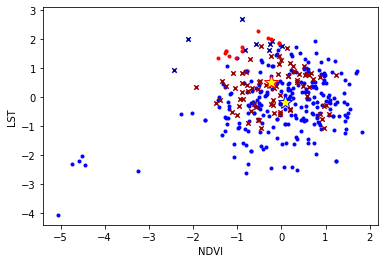

In [25]:
LDA_2D_plot(0, 1)

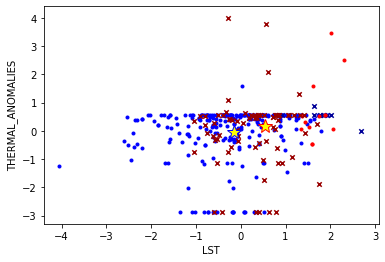

In [26]:
LDA_2D_plot(1, 2)

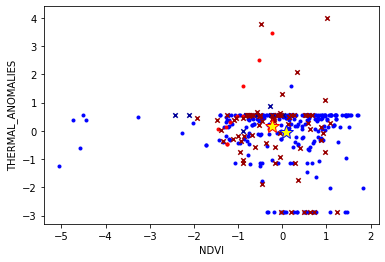

In [27]:
LDA_2D_plot(0, 2)

### Principal Component Analysis (PCA)

<div class="alert alert-block alert-success">
Theoretical backing: Principal Component Analysis (PCA) finds a set of new variables that the original variables 
    are just their linear combinations. The new variables are called Principal Components 
    (PCs). PCA can be used reduce the dimensionality of a dataset consisting of a large number of related variables (in our case, only 3) while retaining as much variance in the data as possible.
    </div>

In [28]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3'])
explained_variance = pca.explained_variance_ratio_
print("Explained variance:", explained_variance)

Explained variance: [0.39081512 0.34495313 0.26423175]


<div class="alert alert-block alert-success">
The first and second principal components account for 39% and 34% of the variance, respectively.
We often want to keep only the significant features and drop the insignificant ones. 
A rule of thumb is to keep the top principal components that capture significant variance and ignore the small ones. Therefore, we will focus on the first two principal components for the purposes of dimensionality reduction.
</div>

In [29]:
pca_df = pd.concat([principalDf, df_WildFires[['CLASS']]], axis = 1)
pca_df.head()

,PC1,PC2,PC3,CLASS
0,-0.164716,0.496015,-0.126917,0
1,0.355247,0.550875,0.137757,0
2,0.954190,-1.030854,0.617664,1
3,-4.906019,3.803911,-0.757437,0
4,0.631110,0.071215,0.184330,0


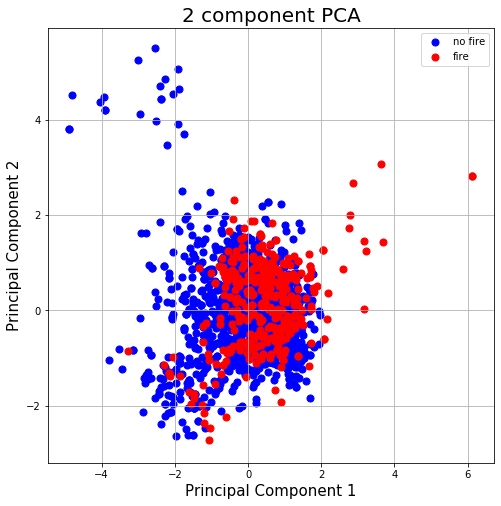

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
labels = ['no fire', 'fire']
colors = ['b', 'r']
for target, color in zip(targets,colors):
    ax.scatter(pca_df.loc[pca_df['CLASS'] == target, 'PC1'],
               pca_df.loc[pca_df['CLASS'] == target, 'PC2'],
               c = color, s = 50)
ax.legend(labels)
ax.grid()

Some machine learning packages will not include functionality to balance the class weights when training the model. However, we can still balance the classes. One method for doing so is called SMOTE (Synthetic Minority Over-sampling). This is available within the imbalanced-learn package in python. https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html. The cell below demonstrates how SMOTE can be executed on the training dataset to balance the classes.

In [31]:
from imblearn.over_sampling import SMOTE

# Balance the classes using SMOTE
os = SMOTE(random_state = 0)
os_data_X,os_data_y = os.fit_sample(X_train, y_train)

# Train a logistic regression model using the training data set
lda_SMOTE = LinearDiscriminantAnalysis(store_covariance =  True)
lda_SMOTE.fit(os_data_X, os_data_y)

# Using the logistic regression model, predict whether or not their is a fire in each test observation
y_pred = lda_SMOTE.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.668
The confusion matrix is:
[[173  83]
 [ 31  56]]


The accuracy and confusion matrix is similar to the logistic regression with balanced class weights.

An LDA assumes the same covariance matrix for all classes. The covariance matrix for each of the LDA models can be seen below.

In [32]:
lda.covariance_

array([[ 0.97744345,  0.10444568, -0.02504435],
       [ 0.10444568,  0.89988647,  0.13903204],
       [-0.02504435,  0.13903204,  0.97133665]])

In [33]:
lda_SMOTE.covariance_

array([[ 0.84600253,  0.02511204, -0.04541701],
       [ 0.02511204,  0.7603654 ,  0.12703735],
       [-0.04541701,  0.12703735,  0.97466846]])

In [34]:
specificity_lda_bal = specificity(cnf_matrix)
sensitivity_lda_bal = sensitivity(cnf_matrix)
precision_lda_bal = precision(cnf_matrix)

In [35]:
print("Specificity:\t", specificity_lda_bal)
print("Sensitivity:\t", sensitivity_lda_bal)
print("Precision:\t", precision_lda_bal)

Specificity:	 0.676
Sensitivity:	 0.644
Precision:	 0.403


### 4. Quadratic Discriminant Analysis (QDA)

Let's calculate the covariance matrix for all classes. Then let's separate the training data set by class (fire and no_fire) and calculate the covariance matrices for each class separately.

In [36]:
# need to transpose the matrix to get the covariance of each feature with every other feature
np.cov(X_train.T)

array([[ 0.99492945,  0.06727851, -0.0359617 ],
       [ 0.06727851,  0.98324556,  0.16333571],
       [-0.0359617 ,  0.16333571,  0.97912876]])

In [37]:
# Isolate the predictive variable (features) in X

df_neg = df_WildFires.loc[df_WildFires["CLASS"] == 0]
df_pos = df_WildFires.loc[df_WildFires["CLASS"] == 1]

def get_covariance_matrix(df):
    y_obs = df["CLASS"]
    X = df.drop(["CLASS"], axis = 1)

    # Standardize the predictive variable (features)
    X_std = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_std, y_obs, 
                                                    test_size = 0.2, # 20% of the data is in the test set and 80% of the data is in the training set
                                                    random_state = 0)
    
    return np.cov(X_train.T)

In [38]:
get_covariance_matrix(df_neg)

array([[ 0.99033544,  0.18845377, -0.01828629],
       [ 0.18845377,  0.99593107,  0.13087879],
       [-0.01828629,  0.13087879,  1.03184707]])

In [39]:
get_covariance_matrix(df_pos)

array([[ 0.98534453, -0.14367813, -0.1161745 ],
       [-0.14367813,  1.01214845,  0.18250253],
       [-0.1161745 ,  0.18250253,  1.09871397]])

<div class="alert alert-block alert-success">
Based on these covariance matrices, we would expect QDA to differ only slightly from LDA. The absolute values of the covariances
are similar, but there are subtle differences between the covariance matrix for the positive ("fire") class compared to the covariance 
matrix for the negative ("no fire") class. We can expect to see decent performance of QDA 
because unlike LDA, QDA assumes that each class has its own covariance matrix, which is generally true as we can see above.
</div>

Let's train and test a QDA model. Then, as usual, we will print out the accuracy of the model and the confusion matrix. Information on QDA capabilities in scikit-learn can be found at https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html.

In [40]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Train an LDA model using the training data set
qda = QuadraticDiscriminantAnalysis(store_covariance =  True)
qda.fit(X_train, y_train)

# Use the LDA model to predict whether or not there is a fire in each test observation
y_pred = qda.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.758
The confusion matrix is:
[[246  10]
 [ 73  14]]


In [41]:
qda.covariance_

[array([[ 1.05837473,  0.16231101, -0.01169359],
        [ 0.16231101,  0.97610536,  0.13516762],
        [-0.01169359,  0.13516762,  0.89826144]]),
 array([[ 0.69341128, -0.10262482, -0.07314975],
        [-0.10262482,  0.63225412,  0.15384074],
        [-0.07314975,  0.15384074,  1.24023985]])]

In [42]:
specificity_qda = specificity(cnf_matrix)
sensitivity_qda = sensitivity(cnf_matrix)
precision_qda = precision(cnf_matrix)

In [43]:
print("Specificity:\t", specificity_qda)
print("Sensitivity:\t", sensitivity_qda)
print("Precision:\t", precision_qda)

Specificity:	 0.961
Sensitivity:	 0.161
Precision:	 0.583


Let's again balance the class weights when training the model. One method for doing so is called SMOTE (Synthetic Minority Over-sampling).

In [44]:
# Balance the classes using SMOTE
os = SMOTE(random_state = 0)
os_data_X,os_data_y = os.fit_sample(X_train, y_train)

# Train a logistic regression model using the training data set
qda_SMOTE = QuadraticDiscriminantAnalysis(store_covariance =  True)
qda_SMOTE.fit(os_data_X, os_data_y)

# Using the logistic regression model, predict whether or not their is a fire in each test observation
y_pred = qda_SMOTE.predict(X_test)

# Print the accuracy and confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print('The accuracy of this model is %.3f' %accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

The accuracy of this model is 0.641
The confusion matrix is:
[[158  98]
 [ 25  62]]


In [45]:
qda_SMOTE.covariance_

[array([[ 1.05837473,  0.16231101, -0.01169359],
        [ 0.16231101,  0.97610536,  0.13516762],
        [-0.01169359,  0.13516762,  0.89826144]]),
 array([[ 0.63521164, -0.11203999, -0.07922533],
        [-0.11203999,  0.54604667,  0.11914453],
        [-0.07922533,  0.11914453,  1.0528973 ]])]

In [46]:
specificity_qda_bal = specificity(cnf_matrix)
sensitivity_qda_bal = sensitivity(cnf_matrix)
precision_qda_bal = precision(cnf_matrix)

In [47]:
print("Specificity:\t", specificity_qda_bal)
print("Sensitivity:\t", sensitivity_qda_bal)
print("Precision:\t", precision_qda_bal)

Specificity:	 0.617
Sensitivity:	 0.713
Precision:	 0.388


### 5. Model Comparison

We have now explored Logistic regression, LDA, and QDA models. Let's plot ROC curves for all three models on the same graph and also compute the AUC for each model.

In [48]:
# Original Logistic Regression Model
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Balanced Logistic Regression Model
probs_balanced = logreg_balanced.predict_proba(X_test)
preds_balanced = probs_balanced[:,1]
fpr_balanced, tpr_balanced, threshold = metrics.roc_curve(y_test, preds_balanced)
roc_auc_balanced = metrics.auc(fpr_balanced, tpr_balanced)

# Scikit-learn uses a default threshold value of 0.5

# From the confusion matrix, you can plot the operating characteristic for the model
# Original Logistic Regression 
fpr_50 = 1 - specificity_lr
tpr_50 = sensitivity_lr
# Balanced Logistic Regression Model
fpr_50_balanced = 1 - specificity_lr_bal
tpr_50_balanced = sensitivity_lr_bal

In [49]:
# Original Logistic Regression Model
probs = lda.predict_proba(X_test)
preds = probs[:,1]
lda_fpr, lda_tpr, threshold = metrics.roc_curve(y_test, preds)
lda_roc_auc = metrics.auc(lda_fpr, lda_tpr)
lda_fpr_50 = 1 - specificity_lda
lda_tpr_50 = sensitivity_lda

# Balanced Logistic Regression Model
probs_balanced = lda_SMOTE.predict_proba(X_test)
preds_balanced = probs_balanced[:,1]
lda_fpr_balanced, lda_tpr_balanced, threshold = metrics.roc_curve(y_test, preds_balanced)
lda_roc_auc_balanced = metrics.auc(lda_fpr_balanced, lda_tpr_balanced)
lda_fpr_50_balanced = 1 - specificity_lda_bal
lda_tpr_50_balanced = sensitivity_lda_bal

In [50]:
# Original Logistic Regression Model
probs = qda.predict_proba(X_test)
preds = probs[:,1]
qda_fpr, qda_tpr, threshold = metrics.roc_curve(y_test, preds)
qda_roc_auc = metrics.auc(qda_fpr, qda_tpr)
qda_fpr_50 = 1 - specificity_qda
qda_tpr_50 = sensitivity_qda

# Balanced Logistic Regression Model
probs_balanced = qda_SMOTE.predict_proba(X_test)
preds_balanced = probs_balanced[:,1]
qda_fpr_balanced, qda_tpr_balanced, threshold = metrics.roc_curve(y_test, preds_balanced)
qda_roc_auc_balanced = metrics.auc(qda_fpr_balanced, qda_tpr_balanced)
qda_fpr_50_balanced = 1 - specificity_qda_bal
qda_tpr_50_balanced = sensitivity_qda_bal


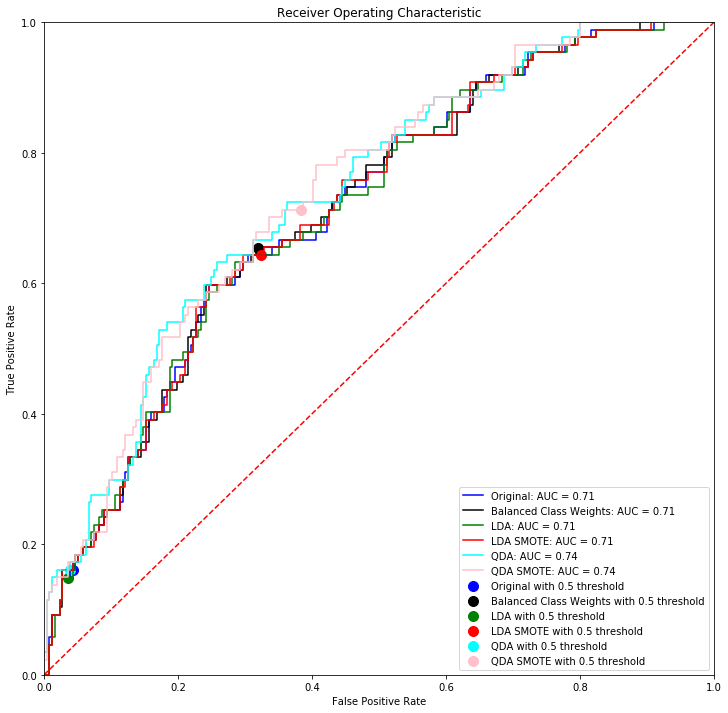

In [51]:
# Create ROC curve plot
fig = plt.figure(figsize=(12, 12))

plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'Original: AUC = %0.2f' % roc_auc)
plt.scatter(fpr_50, tpr_50, s=100, marker='o', c='b', label = 'Original with 0.5 threshold')
plt.plot(fpr_balanced, tpr_balanced, 'black', label = 'Balanced Class Weights: AUC = %0.2f' % roc_auc_balanced)
plt.scatter(fpr_50_balanced, tpr_50_balanced, s=100, marker='o', c='black', label = 'Balanced Class Weights with 0.5 threshold')

plt.plot(lda_fpr, lda_tpr, 'g', label = 'LDA: AUC = %0.2f' % lda_roc_auc)
plt.scatter(lda_fpr_50, lda_tpr_50, s=100, marker='o', c='g', label = 'LDA with 0.5 threshold')
plt.plot(lda_fpr_balanced, lda_tpr_balanced, 'r', label = 'LDA SMOTE: AUC = %0.2f' % lda_roc_auc_balanced)
plt.scatter(lda_fpr_50_balanced, lda_tpr_50_balanced, s=100, marker='o', c='r', label = 'LDA SMOTE with 0.5 threshold')

plt.plot(qda_fpr, qda_tpr, 'cyan', label = 'QDA: AUC = %0.2f' % qda_roc_auc)
plt.scatter(qda_fpr_50, qda_tpr_50, s=100, marker='o', c='cyan', label = 'QDA with 0.5 threshold')
plt.plot(qda_fpr_balanced, qda_tpr_balanced, 'pink', label = 'QDA SMOTE: AUC = %0.2f' % qda_roc_auc_balanced)
plt.scatter(qda_fpr_50_balanced, qda_tpr_50_balanced, s=100, marker='o', c='pink', label = 'QDA SMOTE with 0.5 threshold')


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Which model is best for classifying the images as fire or no_fire?

<div class="alert alert-block alert-success">
I would suggest using QDA (with SMOTE) because it has the highest AUC score while also having high precision. We want to balance the weight of the classes for this particular data that we are working with because we do not want our classifier to learn to predict no wildfire with great specificity but exhibit subpar performance for the prediction of wildfires. After all, the severity of this prediction task is such that we want the highest possible precision. QDA with SMOTE gives relatively advantageous results because the decision boundaries for this dataset are moderately non-linear, it seems.
</div>

How might one be able to improve the classification of fire/no_fire observations? Are their other predictive features that could be useful? The process of selecting appropriate features is called feature engineering, and is one of the most important parts of data science. Are their other models that may be better (the journal discusses some alternative models)?

<div class="alert alert-block alert-success">
I agree with the future work proposed in the paper. Weather data should be included because 
"weather plays a major role in the occurrence, growth, spread and the extinction of wildfires."
The dataset could be augmented with 3 additional features: air temperature, wind, and soil moisture. 
When air temperature is high, the risk of wildfires is high. When wind speeds are fast, fires become more dangerous and unpredictable. And finally,
when soil moisture is low, the risk of wildfires is high. These three features may be able to help train these models to have better classification performance.</div>